# MNIST

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

from keras.layers import concatenate, Dense, Reshape, BatchNormalization, Activation, Conv2DTranspose
from keras.layers import Conv2D, LeakyReLU, Flatten

In [3]:
def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan"):
    """
    # Arguments
        generator (Model)
        noise_input (ndarray)
        show (bool)
        step (int)
        model_name (string)

    """
    filepath = os.path.join(model_name, "generated")
    os.makedirs(filepath, exist_ok=True)
    
    filename = os.path.join(filepath, "%05d.png" %step)
    
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input, verbose=None)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [4]:
def build_generator(inputs, image_size):
    # Stack: BN-ReLU-Conv2DTranspose
    # inputs: z-vector(noise)
    # image_size: Target size
    # return: Model
    
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    
    x = Dense(image_resize*image_resize*layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)
    
    for filters in layer_filters:
        # 1st, 2nd Conv layers: strides = 2
        # 3rd, 4th Conv layers: strides = 1
        if filters > layer_filters[-2]: #128, 64
            strides = 2
        else:
            strides = 1
        # BN-ReLU-Conv2DTranspose
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same'
                           )(x)
        
    x = Activation('sigmoid')(x)
    generator = keras.Model(inputs, x, name='generator')
    return generator

In [5]:
def build_discriminator(inputs):
    # BN으로는 수렴하지 않음
    # Stack: LeakyReLU-Conv2D
    # inputs: Image
    # return: Model
    
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    
    x = inputs
    
    for filters in layer_filters:
        # 1st, 2nd, 3rd Conv layers: strides = 2
        # 4th Conv layers: strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        # LeakyReLU-Conv2D
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same'
                  )(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = keras.Model(inputs, x, name='discriminator')
    return discriminator

In [6]:
def build_and_train_models():
    (x_train, _), (_, _) = keras.datasets.mnist.load_data()
    
    # Reshape & Normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32')/255
    
    model_name = 'MNIST_DCGAN'
    # Network Params
    latent_size = 100 # z-vector dimension
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8 # decays the lerning rate over time
    input_shape = (image_size, image_size, 1)

    # In Keras 2.11.0, 'decay' argument changed to 'weight_decay'
    # Discriminator model
    inputs = keras.Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = keras.optimizers.legacy.RMSprop(learning_rate=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy']
                        )
    discriminator.summary()
    keras.utils.plot_model(model=discriminator,
                           to_file=os.path.join(model_name, "discriminator.png"),
                           show_shapes=False
                          )
    
    # Generator model
    input_shape = (latent_size, )
    inputs = keras.Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()
    keras.utils.plot_model(model=generator,
                           to_file=os.path.join(model_name, "generator.png"),
                           show_shapes=False
                          )
    
    # Adversarial model
    optimizer = keras.optimizers.legacy.RMSprop(learning_rate=lr*0.5,
                                         decay=decay*0.5,
                                        )
    discriminator.trainable = False
    ## Adversarial = Generator + Discriminator
    adversarial = keras.Model(inputs, discriminator(generator(inputs)), name='adversarial')
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy']
                       )
    adversarial.summary()
    keras.utils.plot_model(model=adversarial,
                           to_file=os.path.join(model_name, "adversarial.png"),
                           show_shapes=False
                          )
    
    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name)
    train(models, x_train, params)

In [7]:
def train(models, x_train, params):
    # Discriminator와 Adversarial Model을 배치 단위로 번갈아 훈련
    ## Discriminator는 제대로 레이블이 붙은 진짜와 가짜 이미지를 가지고 훈련
    ## Adversarial는 진짜인 척하는 가짜 이미지로 훈련
    
    # GAN Model
    generator, discriminator, adversarial = models
    
    # Network Params
    batch_size, latent_size, train_steps, model_name = params
    
    # Save Generator Images every 500 epochs
    save_interval = 500
    
    # Noise_Input
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size]) # 16 x 100
    train_size = x_train.shape[0]
    for i in range(train_steps): # train_steps: 40,000
        # First - Discriminator Train
        # Real Images
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        
        # Fake Images
        # Make noise by using Uniform Distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise, verbose=None)
        
        # x: Real Images + Fake Images
        x = np.concatenate((real_images, fake_images))
        # y: real_images-1, fake_images-0
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0.0
        
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" %(i, loss, acc)
        
        # Second - Adversarial Train
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s: [adversarial loss: %f, acc: %f]" %(log, loss, acc)
        
        if i % 100 == 0:
            print(log)
        
        # Show generator images per 500 epochs
        if (i+1) % save_interval == 0: # 500
            if (i+1) == train_steps: # 40,000
                show = True
            else:
                show = False
                
            # Make generator images per 500 epochs
            plot_images(generator,
                        noise_input=noise_input,
                        show=show,
                        step=(i+1),
                        model_name=model_name
                       )
        
    generator.save(model_name + "/mnist_dcgan.h5")

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                     

2023-06-30 09:03:59.347034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7924 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:65:00.0, compute capability: 8.0


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      409728    
 nspose)                                                 

2023-06-30 09:04:01.063547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-30 09:04:01.223930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


0: [discriminator loss: 0.696846, acc: 0.468750]: [adversarial loss: 1.056853, acc: 0.000000]
100: [discriminator loss: 0.000132, acc: 1.000000]: [adversarial loss: 0.000000, acc: 1.000000]
200: [discriminator loss: 0.000065, acc: 1.000000]: [adversarial loss: 0.000001, acc: 1.000000]
300: [discriminator loss: 0.000114, acc: 1.000000]: [adversarial loss: 0.000000, acc: 1.000000]
400: [discriminator loss: 0.089088, acc: 0.992188]: [adversarial loss: 2.878140, acc: 0.000000]
500: [discriminator loss: 0.038052, acc: 1.000000]: [adversarial loss: 0.018475, acc: 1.000000]
600: [discriminator loss: 0.056009, acc: 0.976562]: [adversarial loss: 0.013148, acc: 1.000000]
700: [discriminator loss: 0.458729, acc: 0.796875]: [adversarial loss: 0.990883, acc: 0.250000]
800: [discriminator loss: 0.485104, acc: 0.820312]: [adversarial loss: 1.007214, acc: 0.250000]
900: [discriminator loss: 0.607471, acc: 0.632812]: [adversarial loss: 0.530352, acc: 0.750000]
1000: [discriminator loss: 0.554150, acc: 

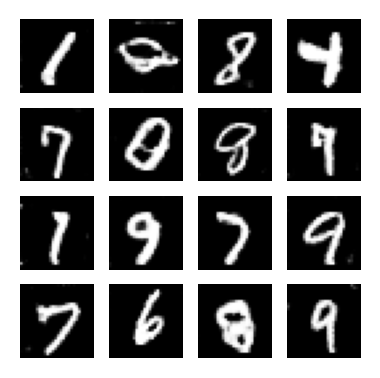

In [8]:
if __name__=="__main__":
    build_and_train_models()

2023-07-02 13:34:42.536493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


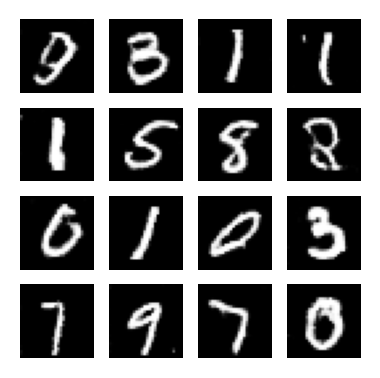

In [5]:
from keras.models import load_model

generator = load_model("./MNIST_DCGAN/mnist_dcgan.h5")
noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
plot_images(generator,
            noise_input=noise,
            show=True,
            model_name="./MNIST_DCGAN/test_image"
           )

In [25]:
"""
import argparse

def test_generator(generator):
    noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
    plot_images(generator,
            noise_input=noise,
            show=True,
            model_name="test_image"
           )

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load generator h5 model with trained weights"
    parser.add_argument("-g", "--generator", help=help_)
    args = parser.parse_args() # args에 위 내용 저장
    if args.generator:
        generator = load_model(args.generator)
        test_generator(generator)
    else:
        build_and_train_models()
"""